<a href="https://colab.research.google.com/github/ahmabboud/Pizza-Coocking-Level-Recognition/blob/main/Label_Smoothing_Baseline_model_ovenPizza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pizza Doneness Project

The aim of the project is to build a model capable of detecting/classifying how done the pizza is inside the oven with the following labels (light, medium, dark)

### The outline of the notebook is as follows:


- Read training and testing data from csv file
- Creating a dataloader and visualizing some of the data that we will train on as well as doing slight data augmentation
- Creating our cnn learner with a resnet50 architecure and
using accuracy as our evaluation metric
- Training our Model
- Plotting the confusion matrix as well as visualizing some of the misclassified images during validation
- Testing the model with the data of each class to better understand which class is harder to classify/detect
- Printing out the total accuracy that is achieved

### Importing necessary libraries


In [ ]:
!pip install fastai --upgrade --q

In [ ]:
from fastai.vision.all import *

### Seeding everything for reproducible results

In [ ]:
# def seed_everything(seed):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True 

# seed_everything(42)

### Read training and testing data from csv files

In [ ]:
# ## Pizza doneness wild training set

# train_path = "/content/drive/My Drive/datasets/pizza_doneness_wild/bismay_n_moaz/"
# train_label_path = "/content/drive/My Drive/datasets/pizza_doneness_wild/bismay_n_moaz.csv"

# train_csv = pd.read_csv(train_label_path)
# train_csv['file_name'] = train_csv['file_name'].apply(lambda x: str(train_path) + x)

# ## Pizza doneness wild testing set

test_path = "/content/drive/My Drive/datasets/oven_pizza/imgs/"
test_label_path = "/content/drive/My Drive/datasets/oven_pizza/raw_light_oven_pizzas_labels.csv"

# ## New Pizza doneness wild testing set

# #test_path = "/content/drive/My Drive/datasets/pizza-doneness-final-datasets-for-bismay/new_oven_pizza_test_set_3labels/images/"
# #test_label_path = "/content/drive/My Drive/datasets/pizza-doneness-final-datasets-for-bismay/new_oven_pizza_test_set_3labels.csv"

# ## New Pizza doneness testing set 12K

# #test_path = "/content/drive/My Drive/datasets/Pizza_Test_11_4/"
# #test_label_path = "/content/drive/My Drive/datasets/12k_testset_labels.csv"

test_csv = pd.read_csv(test_label_path)
# test_csv = test_csv[test_csv['labeled_class'] != 'raw']
test_csv['file_name'] = test_csv['file_name'].apply(lambda x: str(test_path) + x)# + ".png")
test_csv = test_csv.rename(columns={'file_name': 'image_name'})
test_csv = test_csv.rename(columns={'labeled_class': 'label'})

In [ ]:
train_test_path = "/content/drive/My Drive/datasets/Pizza_Test_11_4/"

train_label_path = "/content/drive/My Drive/datasets/Pizza_train_sessions_v2.csv"

train_csv = pd.read_csv(train_label_path)
train_csv = train_csv[train_csv['label'] != 'raw']
train_csv['image_name'] = train_csv['image_name'].apply(lambda x: str(train_test_path) + x  + ".png")

#test_label_path = "/content/drive/My Drive/datasets/Pizza_test_sessions_v2.csv"

#test_csv = pd.read_csv(test_label_path)
#test_csv = test_csv[test_csv['label'] != 'raw']
#test_csv = test_csv[test_csv['pizza_levels'] != 2]
#test_csv = test_csv[test_csv['pizza_levels'] != 3]
#test_csv['image_name'] = test_csv['image_name'].apply(lambda x: str(train_test_path) + x + ".png")

In [ ]:
print(f"Training dataset contains {len(train_csv['image_name'])} images: ")
print("   ")
print("Class  | Images")
print("================")
train_csv['pizza_levels'].value_counts().sort_index()

Training dataset contains 1494 images: 
   
Class  | Images


4       2
5       1
6      14
7      32
8      49
9      54
10     59
11     90
12    184
13    265
14    201
15    202
16    166
17     91
18     54
19     30
Name: pizza_levels, dtype: int64

In [ ]:
print(f"Testing dataset contains {len(test_csv['image_name'])} images: ")
print("   ")
print("Class  | Images")
print("================")
test_csv['label'].value_counts().sort_index()

Testing dataset contains 301 images: 
   
Class  | Images


dark       40
light     165
medium     96
Name: label, dtype: int64

In [ ]:
# Training parameters

ep_frzn = 4
lr_frzn = 2e-3  #1e-3

ep_ufrzn = 12
lr_ufrzn = slice(3e-5, 8e-3)  #(1e-5 1e-3)

wd1 = 0.2
wd2 = 0.2

loss_func = LabelSmoothingCrossEntropy()

#callback = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.05, patience=3)

### Creating a dataloader and visualizing some of the data that we will train

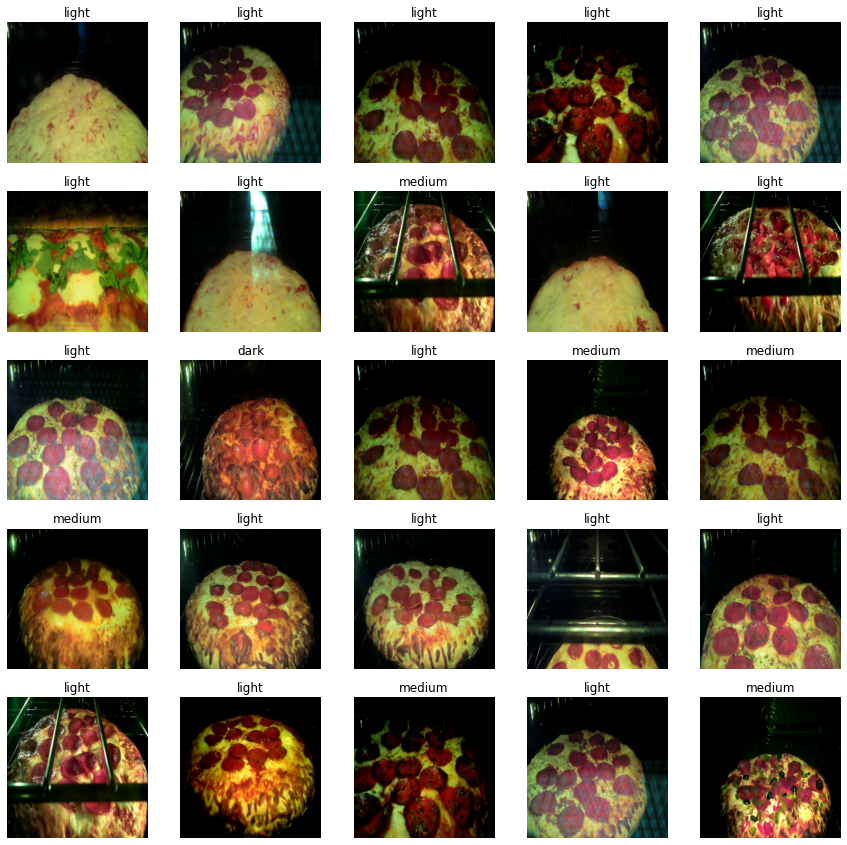

In [ ]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
          get_x  = ColReader("image_name"),
          get_y  = ColReader("label"),
          item_tfms = RandomResizedCrop(256, min_scale = 0.3),
          splitter = RandomSplitter(valid_pct=0.2, seed=42))
  
dls = dblock.dataloaders(train_csv, seed = 42, num_workers=0)
dls.valid.show_batch(max_n=25, nrows=5)

### Training the model with resnet50 architecture and using accuracy metric for evaluation

In [ ]:
learn = cnn_learner(dls, models.densenet161, metrics=accuracy, loss_func = loss_func).to_fp16()
#models.densenet161

In [ ]:
learn.fit_one_cycle(ep_frzn, lr_frzn, wd=wd1) #, cbs = callback)

epoch,train_loss,valid_loss,accuracy,time
0,1.965055,1.970664,0.436242,01:32
1,1.531402,0.757535,0.775168,01:23
2,1.210500,0.603376,0.815436,01:23
3,1.022254,0.515486,0.885906,01:23


In [ ]:
#learn.save("Baseline_model_ovenPizza_stage_1")

## Stage 2

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(ep_ufrzn, lr_ufrzn, wd=wd2) #, cbs = callback)

epoch,train_loss,valid_loss,accuracy,time
0,0.718672,0.721181,0.825503,01:31


In [ ]:
#learn.save("Baseline_model_ovenPizza_stage_2")

### Plotting Confusion matrix and visualizing top losses during training

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize= (10,10), dpi = 60)

In [ ]:
interp.plot_top_losses(25, nrows=5)

### Creating a dataloader for the testset and and visualizing the results as well as the top losses on the testset

In [ ]:
test_dataloader = dls.test_dl(test_csv, with_labels=True)
interp = ClassificationInterpretation.from_learner(learn, dl = test_dataloader)
interp.plot_confusion_matrix(figsize= (10,10), dpi = 60)

In [ ]:
interp.plot_top_losses(25, nrows=5)

In [ ]:
preds, targs = learn.get_preds(dl=test_dataloader)
print(f'Model has an accuracy of {accuracy(preds, targs).item() *100}% on testset.')

In [ ]:
#learn.save("Baseline_model_ovenPizza")

In [ ]:
#learn.export("Baseline_model_ovenPizza.pkl")